In [1]:
import pickle
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt 
# https://towardsdatascience.com/random-forest-in-python-24d0893d51c0

## Data loading and processing
the target variable “flow” in cubic meters per second at a single location <br>
the predictor precipitation “obs_pr” in mm at 9 surrounding locations <br>
the predictor temperature “obs_tas” in Celsius at 9 surrounding locations

In [2]:
path = '/home/germanm2/climateAI_assignment/uke_eggedal_data_challenge.pkl'

with open(path, 'rb') as f:
    data_dict = pickle.load(f)

In [3]:
data_dict.keys()

dict_keys(['flow', 'obs_tas', 'flow_dates', 'obs_lon_lat', 'obs_pr', 'obs_dates'])

In [4]:
length_dict = {key: len(value) for key, value in data_dict.items()}
length_dict

{'flow': 21542,
 'obs_tas': 21546,
 'flow_dates': 21542,
 'obs_lon_lat': 2,
 'obs_pr': 21546,
 'obs_dates': 21546}

Get all the x data and combine it into one dataframe

In [29]:
#Process the x data
x_df1 = pd.DataFrame(data=data_dict['obs_tas'], columns=["T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9"]).reset_index(drop=True)
x_df2 = pd.DataFrame(data=data_dict['obs_pr'], columns=["P1", "P2", "P3", "P4", "P5", "P6", "P7", "P8", "P9"]).reset_index(drop=True)
x_df3 = pd.DataFrame(data=data_dict['obs_dates'], columns=["obs_dates"]).reset_index(drop=True)
x_data_df = pd.concat([x_df1, x_df2, x_df3], axis=1)

Get the y data and combine it into one data frame. Add the flow on the previous day

In [33]:
# Process the y data
y_df1 = pd.DataFrame(data=data_dict['flow'], columns=["flow"]).reset_index(drop=True)
y_df2 = pd.DataFrame(data=data_dict['flow_dates'], columns=["flow_dates"]).reset_index(drop=True)
y_data_df = pd.concat([y_df1, y_df2], axis=1)
y_data_df['flow-1'] = y_data_df['flow'].shift(1)
y_data_df

,flow,flow_dates,flow-1
0,1.723781,1958-01-04,NaN
1,0.960882,1958-01-05,1.723781
2,0.001000,1958-01-06,0.960882
3,0.001000,1958-01-07,0.001000
4,0.316796,1958-01-08,0.001000
...,...,...,...
21537,4.843290,2016-12-22,4.109478
21538,3.756970,2016-12-23,4.843290
21539,3.556818,2016-12-24,3.756970
21540,3.402133,2016-12-25,3.556818


Add the doy and the average flow for each doy (will be the baselevel guess)

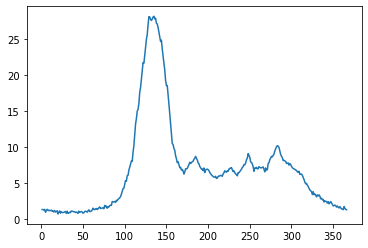

In [34]:
# Add the doy
y_data_df['doy'] = [x.timetuple().tm_yday for x in y_data_df['flow_dates']]
average_flow = y_data_df.groupby('doy')['flow'].mean()
y_data_df = pd.merge(y_data_df, average_flow, left_on='doy', right_index=True,suffixes= ('','_doy')).sort_values(by=['flow_dates'])

#Plot the average flow along the year
plt.plot(average_flow.index ,average_flow)

For each y data, add the x data from the previous 10 days

In [35]:
# Add the shifted x data
for shift_n in range(1, 10):
    data_tmp = x_data_df.copy()
    data_tmp['obs_dates'] = data_tmp['obs_dates'] + np.timedelta64(shift_n,'D')

    keep_same = {'obs_dates'}
    data_tmp.columns = ['{}{}'.format(c, '' if c in keep_same else '-'+str(shift_n)) for c in data_tmp.columns]
    data_tmp
    y_data_df = pd.merge(y_data_df, data_tmp, left_on='flow_dates', right_on='obs_dates')
    y_data_df = y_data_df.drop(['obs_dates'], axis = 1)
y_data_df

,flow,flow_dates,flow-1,doy,flow_doy,T1-1,T2-1,T3-1,T4-1,T5-1,...,T9-9,P1-9,P2-9,P3-9,P4-9,P5-9,P6-9,P7-9,P8-9,P9-9
0,1.723781,1958-01-04,NaN,4,1.379884,-17.5,-17.1,-18.6,-17.4,-16.9,...,-4.0,1.0,0.2,1.5,0.9,1.0,1.1,3.0,1.8,1.4
1,0.960882,1958-01-05,1.723781,5,0.967150,-12.8,-13.0,-13.0,-12.5,-12.5,...,0.7,0.0,0.0,0.0,0.1,0.1,0.0,0.0,0.0,0.0
2,0.001000,1958-01-06,0.960882,6,1.184324,-7.8,-7.9,-8.4,-7.0,-7.3,...,4.9,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.001000,1958-01-07,0.001000,7,1.372209,-11.0,-9.9,-6.5,-8.5,-9.0,...,-0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.316796,1958-01-08,0.001000,8,1.290531,-13.2,-12.2,-7.9,-10.7,-11.3,...,-6.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21150,4.876250,2015-12-28,2.177040,362,1.333231,-12.5,-11.7,-8.6,-11.0,-10.9,...,-0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21151,4.998840,2015-12-29,4.876250,363,1.752376,-12.5,-11.9,-9.1,-11.4,-11.2,...,2.8,0.0,0.0,0.1,0.0,0.0,0.9,0.0,0.0,2.3
21152,4.428777,2015-12-30,4.998840,364,1.532236,-11.9,-11.4,-8.4,-10.8,-10.8,...,6.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,1.2,0.0
21153,4.047925,2015-12-31,4.428777,365,1.355514,-7.0,-6.5,-3.4,-5.9,-6.1,...,3.7,0.1,0.0,0.1,0.2,0.1,0.0,0.0,0.0,0.0


In [36]:
# Identify Anomalies/ Missing Data
data_df = y_data_df.dropna()
# Descriptive statistics for each column
data_df.describe()

,flow,flow-1,doy,flow_doy,T1-1,T2-1,T3-1,T4-1,T5-1,T6-1,...,T9-9,P1-9,P2-9,P3-9,P4-9,P5-9,P6-9,P7-9,P8-9,P9-9
count,21154.000000,21154.000000,21154.000000,21154.000000,21154.000000,21154.000000,21154.000000,21154.000000,21154.000000,21154.000000,...,21154.000000,21154.000000,21154.000000,21154.000000,21154.000000,21154.000000,21154.000000,21154.000000,21154.000000,21154.000000
mean,6.915211,6.915083,183.307460,6.895945,-0.043391,0.718640,2.985038,1.493491,1.279021,2.318597,...,3.534424,1.991198,2.007814,2.075735,2.212901,2.265482,2.215203,2.305914,2.386182,2.256698
std,9.667303,9.667434,105.373087,6.464833,8.261841,8.397055,9.049218,8.571699,8.467380,8.613189,...,8.957424,4.027069,4.349186,4.497942,4.561515,4.758641,4.910862,4.809044,5.426093,5.186416
min,0.000031,0.000031,1.000000,0.733891,-33.799999,-32.599998,-33.299999,-33.700001,-32.799999,-32.200001,...,-30.799999,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.156911,1.156911,92.000000,1.830716,-5.800000,-5.200000,-3.100000,-4.400000,-4.600000,-3.700000,...,-2.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.155399,3.154490,183.000000,6.455089,0.200000,0.900000,3.400000,1.800000,1.500000,2.500000,...,3.700000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,8.600661,8.600661,275.000000,7.854537,6.600000,7.600000,10.600000,8.500000,8.200000,9.500000,...,11.100000,2.500000,2.200000,2.200000,2.600000,2.600000,2.200000,2.600000,2.200000,2.000000
max,85.397653,85.397653,366.000000,28.170082,20.299999,21.200001,23.400000,21.700001,21.700001,22.700001,...,24.000000,61.500000,60.700001,66.800003,64.000000,62.400002,61.299999,64.500000,67.699997,73.699997


Convert the Pandas dataframes to Numpy arrays because that is the way the algorithm works. (I save the column headers, which are the names of the features, to a list to use for later visualization).

In [37]:
# Use numpy to convert to arrays
import numpy as np
# Labels are the values we want to predict
labels = np.array(data_df['flow'])
# Remove the labels from the features
# axis 1 refers to the columns
features= data_df.drop(['flow', 'flow_dates', 'doy'], axis = 1)
# Saving feature names for later use
feature_list = list(features.columns)
# Convert to numpy array
features = np.array(features)

In [38]:
feature_list

['flow-1',
 'flow_doy',
 'T1-1',
 'T2-1',
 'T3-1',
 'T4-1',
 'T5-1',
 'T6-1',
 'T7-1',
 'T8-1',
 'T9-1',
 'P1-1',
 'P2-1',
 'P3-1',
 'P4-1',
 'P5-1',
 'P6-1',
 'P7-1',
 'P8-1',
 'P9-1',
 'T1-2',
 'T2-2',
 'T3-2',
 'T4-2',
 'T5-2',
 'T6-2',
 'T7-2',
 'T8-2',
 'T9-2',
 'P1-2',
 'P2-2',
 'P3-2',
 'P4-2',
 'P5-2',
 'P6-2',
 'P7-2',
 'P8-2',
 'P9-2',
 'T1-3',
 'T2-3',
 'T3-3',
 'T4-3',
 'T5-3',
 'T6-3',
 'T7-3',
 'T8-3',
 'T9-3',
 'P1-3',
 'P2-3',
 'P3-3',
 'P4-3',
 'P5-3',
 'P6-3',
 'P7-3',
 'P8-3',
 'P9-3',
 'T1-4',
 'T2-4',
 'T3-4',
 'T4-4',
 'T5-4',
 'T6-4',
 'T7-4',
 'T8-4',
 'T9-4',
 'P1-4',
 'P2-4',
 'P3-4',
 'P4-4',
 'P5-4',
 'P6-4',
 'P7-4',
 'P8-4',
 'P9-4',
 'T1-5',
 'T2-5',
 'T3-5',
 'T4-5',
 'T5-5',
 'T6-5',
 'T7-5',
 'T8-5',
 'T9-5',
 'P1-5',
 'P2-5',
 'P3-5',
 'P4-5',
 'P5-5',
 'P6-5',
 'P7-5',
 'P8-5',
 'P9-5',
 'T1-6',
 'T2-6',
 'T3-6',
 'T4-6',
 'T5-6',
 'T6-6',
 'T7-6',
 'T8-6',
 'T9-6',
 'P1-6',
 'P2-6',
 'P3-6',
 'P4-6',
 'P5-6',
 'P6-6',
 'P7-6',
 'P8-6',
 'P9-6',
 'T1

In [39]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25)

In [40]:
# We can look at the shape of all the data to make sure we did everything correctly. We expect the training features number of columns to match the testing feature number of columns and the number of rows to match for the respective training and testing features and the labels :
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', train_labels.shape)
print('Testing Features Shape:', test_features.shape)
print('Testing Labels Shape:', test_labels.shape)

Training Features Shape: (15865, 164)
Training Labels Shape: (15865,)
Testing Features Shape: (5289, 164)
Testing Labels Shape: (5289,)


The baseline prediction for our case can be the historical max temperature averages. In other words, our baseline is the error we would get if we simply predicted the average max temperature for all days.

In [45]:
# The baseline predictions are the historical averages
baseline_preds = test_features[:, feature_list.index('flow-1')]
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  1.33


## Train Model

In [43]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor
# Instantiate model with 1000 decision trees
rf = RandomForestRegressor(n_estimators = 1000)
# Train the model on training data
rf.fit(train_features, train_labels);

## Make Predictions on the Test Set

In [44]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2))

Mean Absolute Error: 1.25
